In [1]:
import mne
import matplotlib.pyplot as plt
import numpy as np
import scipy.io

In [2]:
import hdf5storage
file_path = 'indy_20170131_02.mat'
matfile = hdf5storage.loadmat(file_path)

In [3]:
pos_x=matfile['cursor_pos'][:,0]
pos_y=matfile['cursor_pos'][:,1]


In [4]:
target_list=[]
t_list=[]
initial=matfile['target_pos'][0]
positive=[]
for t in range(0,10000):
    if matfile['target_pos'][t][0]==initial[0] and matfile['target_pos'][t][1]==initial[1]:
        continue
    else:
        target_list.append(matfile['t'][t][0])
        t_list.append(t)
        initial=matfile['target_pos'][t]
for t1 in t_list:
    if matfile['target_pos'][t1][0] > matfile['cursor_pos'][t1][0]:
        positive.append(matfile['t'][t1][0])
print(positive)    


[1675.38, 1676.404, 1677.504, 1678.592, 1681.892, 1684.176, 1686.236, 1688.824, 1692.612, 1693.564, 1696.028, 1698.256, 1700.524, 1702.824, 1705.256, 1708.264, 1709.252, 1713.836]


In [5]:
chosen_spike=matfile['spikes'][9][1].squeeze(1)
trial_list=[]
trial_sum=[]
for t2 in positive:
    t2_start=t2-0.1
    t2_end=t2+0.6
    trial=[]
    for i in chosen_spike:
        if i>t2_start and i<=t2_end:
            trial.append(i-t2)
            trial_sum.append(i-t2)
    trial_list.append(trial)
print(trial_list)

[[0.4289403676600614], [-0.019946052005025194, 0.02121833433466236, 0.04427858255871797, 0.15175654254335313, 0.21831587367091743, 0.29130586019755356, 0.36724493693736804, 0.5415279854576056, 0.5573383866569657], [0.2028028941217599, 0.23126980803886, 0.5185194011016847], [0.010548131510859093, 0.1865924424264449, 0.3180317612889212, 0.3557555420841254], [-0.008179248050055321, 0.25424883459095327, 0.367829773151243, 0.4183739052380133], [-0.005241592974471132, 0.20225968134764116], [0.22374404055767627, 0.3594021969709047, 0.3883196664580737], [], [0.0912960015855333, 0.18320931762423243, 0.2360062268303409], [0.08144845083779728, 0.24278826905629103, 0.3850818785517731, 0.5906990116479847], [0.12331510129865819, 0.5778436517987302], [0.11319488444542003, 0.135927455932233, 0.18102396259564557, 0.23488582104869238, 0.2697833903434912, 0.2997658088333992, 0.37103549221637877], [-0.030886627557038082, 0.41164076370364455, 0.4551808059791256], [-0.08560487932095384, 0.030433634092787543

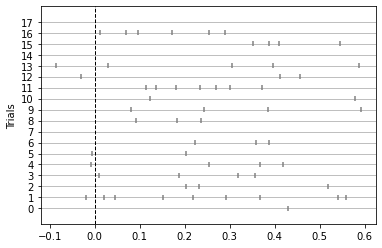

In [6]:
#raster图
line_offset = np.array(range(0, 18, 1))
plt.eventplot(trial_list, lineoffsets=line_offset, linelengths=0.5, colors='grey')
plt.ylabel('Trials')
plt.yticks(np.arange(0, 18))
plt.grid(True, axis='y')
plt.axvline(x=0.0, c='black', linestyle='--', linewidth = 1)
plt.show()

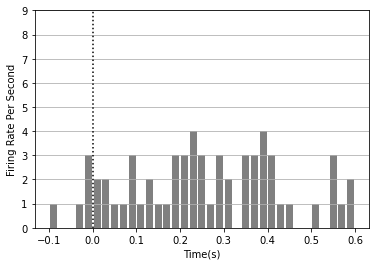

In [7]:
#PSTH图
import math
frate_bin = np.array(np.zeros(35))
trial_sum.sort()
for t in trial_sum:
    spike_bin_index = math.floor((t + 0.1)/0.02)
    frate_bin[spike_bin_index] = frate_bin[spike_bin_index] + 1
plt.bar(np.arange(-0.09, 0.61, 0.02), frate_bin, width = 0.016, color = 'grey')
plt.xlabel('Time(s)')
plt.ylabel('Firing Rate Per Second') 
plt.xticks(np.arange(-0.1, 0.7, 0.1))
plt.yticks(np.arange(0, 10, 1))
plt.grid(True, axis='y')
plt.axvline(x=0.0, c='black', linestyle=':', linewidth = 1.5)

plt.show()

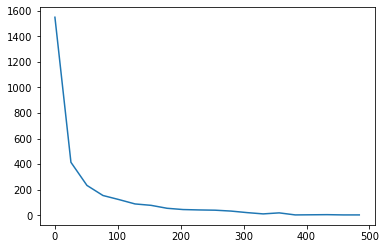

In [35]:
#tuning curve（速度）
speed_bin = np.array(np.zeros(20))
velocity_x = np.diff(pos_x)/0.004
velocity_y = np.diff(pos_y)/0.004
velocity=np.sqrt(velocity_x*velocity_x+velocity_y*velocity_y)
a=matfile['t'].squeeze(1)
v_list=[]
for i in chosen_spike:
    index = np.searchsorted(a, i, side="right") - 1
    v=velocity[index-1]
    v_list.append(v)
min_velocity=np.min(v_list)
max_velocity=np.max(v_list)
bin_width=(max_velocity-min_velocity)/20
for j in v_list:
    bin_index=np.floor((j - min_velocity) / bin_width).astype(int)
    bin_index = np.clip(bin_index, 0, 19)
    speed_bin[bin_index]=speed_bin[bin_index]+1

speed_x=np.arange(min_velocity,max_velocity,bin_width)
plt.plot(speed_x, speed_bin)

r_squared =  0.3274766105899072


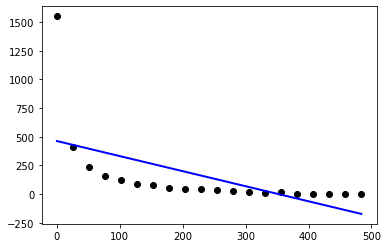

In [41]:
#神经元运动调制分析
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
X=speed_x.reshape(-1, 1)
y=speed_bin
model = LinearRegression()
model.fit(X,y)
y_pred = model.predict(X)
r_2 = r2_score(y, y_pred)
print("r_squared = ", r_2)
plt.scatter(X, y, color='black', label='Actual Discharge ')
plt.plot(X, y_pred, color='blue', linewidth=2, label='Predicted Discharge ')